In [1]:
#hide
from fastai.vision.all import *

matplotlib.rc('image', cmap='Greys')

# Convolutional Neural Networks

In this section, we'll delve into the fundamentals of **convolutions** and build a Convolutional Neural Network (CNN) from scratch. CNNs are powerful tools for image recognition, especially effective in capturing spatial hierarchies within images. We will explore the mechanics of convolutions, discuss kernels and feature maps, and gradually move toward training strategies that stabilize learning and improve performance.

## Introduction to Convolutions

One of the most impactful concepts in image-based machine learning is **feature extraction**—identifying the essential parts of data that help distinguish between classes.

>A *feature* is a transformed version of the data that makes patterns easier to model.

In images, a feature can represent visually distinctive elements like edges, textures, and patterns. For example, distinguishing the number 7 from the number 3 involves identifying a horizontal line near the top (7) and distinguishing it from a more curved structure (3). The presence and orientation of lines or curves are vital characteristics.

So, instead of working directly with raw pixel values, we can leverage **convolutions** to highlight these features, allowing the model to "see" parts of the image that are useful for classification.

### What is a Convolution?

A convolution is a mathematical operation that takes an **input image** and applies a **kernel** to it, producing a feature map that highlights specific structures (edges, textures) in the image. 

Mathematically, for a 2D image $ I $ and a 2D kernel $ K $, a convolution $ S $ at pixel $(i, j)$ is given by:

$$
S(i, j) = \sum_{m=-k}^{k} \sum_{n=-k}^{k} I(i+m, j+n) \cdot K(m, n)
$$

where:
- $ I(i+m, j+n) $ is the pixel value at location $(i+m, j+n)$ in the input image,
- $ K(m, n) $ is the kernel value at $(m, n)$,
- $ k $ is half the kernel width (for a 3×3 kernel, $ k=1 $).

The **kernel** is a small matrix, typically 3×3, which slides across the image. At each location, it multiplies its values with the corresponding values in the image's 3×3 region and sums the result, creating one value in the **output feature map**. 

#### Example: Edge Detection

Consider an edge-detection kernel like:

$$
K = \begin{bmatrix} -1 & -1 & -1 \\ -1 & 8 & -1 \\ -1 & -1 & -1 \end{bmatrix}
$$

Applying this kernel to a region of an image will emphasize regions where pixel values change sharply, helping detect edges. This ability to enhance specific features is what makes convolutions so powerful.

### Convolution in Action

Let's perform a convolution on a small patch of an image. Start by creating a simple 3×3 kernel matrix:



In [2]:
import torch

# Define a 3x3 kernel for edge detection
edge_kernel = torch.tensor([
    [-1.0, -1.0, -1.0],
    [-1.0,  8.0, -1.0],
    [-1.0, -1.0, -1.0]
])



Next, let's apply this kernel across a small sample image to see the effect:


In [3]:
# Example image as a tensor (7x7 grayscale image)
image = torch.tensor([
    [0, 0, 0, 0, 0, 0, 0],
    [0, 255, 255, 255, 255, 255, 0],
    [0, 255, 0, 0, 0, 255, 0],
    [0, 255, 0, 0, 0, 255, 0],
    [0, 255, 0, 0, 0, 255, 0],
    [0, 255, 255, 255, 255, 255, 0],
    [0, 0, 0, 0, 0, 0, 0]
], dtype=torch.float32)

#### Computing the Convolution Output

The kernel will slide over the 7×7 image. At each step, the sum of the element-wise multiplication of the kernel and the 3×3 region of the image will be calculated.

For example, if the kernel is centered over the top-left corner of the `255` region in the image, we calculate:

$$
\text{output}(i, j) = \text{sum}\big(\text{element-wise } \times \text{ }\text{image region and kernel}\big)
$$


In [4]:
# Reshape for convolution (add batch and channel dimensions)
image = image.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 7, 7)
edge_kernel = edge_kernel.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, 3, 3)

# Apply convolution
output = F.conv2d(image, edge_kernel, padding=0)  

print(output[0, 0])  # Display the output

tensor([[ 1530.,  1275.,  1530.,  1275.,  1530.],
        [ 1275., -1275.,  -765., -1275.,  1275.],
        [ 1530.,  -765.,     0.,  -765.,  1530.],
        [ 1275., -1275.,  -765., -1275.,  1275.],
        [ 1530.,  1275.,  1530.,  1275.,  1530.]])


Look at the shape of the result. If the original image has a height of `h` and a width of `w`, how many 3×3 windows can we find? As you can see from the example, there are `h-2` by `w-2` windows, so the image we get has a result as a height of `h-2` and a width of `w-2`.



Convolutions are at the heart of CNNs, helping to create layers of increasingly abstracted feature maps that capture the essential information needed for effective image recognition.


### Convolutions in PyTorch
Convolutions are a fundamental operation in computer vision, and PyTorch provides optimized support for them with the `F.conv2d` function. This function is part of the `torch.nn.functional` module, which fastai imports as `F`. According to the PyTorch documentation, `F.conv2d` requires two main parameters:

- `input`: A tensor of shape `(minibatch, in_channels, iH, iW)`, where `iH` and `iW` represent the height and width of the input image.
- `weight`: A tensor of filters (kernels) of shape `(out_channels, in_channels, kH, kW)`, where `kH` and `kW` are the kernel’s height and width.

Here’s a code example of a simple 2D convolution on a batch of grayscale images with PyTorch:



In [5]:
import torch
import torch.nn.functional as F

# Example input tensor (batch of 1 grayscale 4x4 image)
input_tensor = torch.tensor([[[[1, 2, 0, 1],
                               [0, 1, 3, 1],
                               [1, 2, 0, 2],
                               [0, 1, 1, 0]]]], dtype=torch.float32)

# 3x3 kernel (filter) for convolution
kernel = torch.tensor([[[[1, 0, -1],
                         [1, 0, -1],
                         [1, 0, -1]]]], dtype=torch.float32)

# Apply convolution
output = F.conv2d(input_tensor, kernel)
print(output)


tensor([[[[-1.,  1.],
          [-3.,  1.]]]])


### Strides and Padding
To control the size of the output feature map, we use **padding** and **strides**.

1. **Padding** allows us to maintain the same output size as the input by adding extra pixels (usually zeros) around the edges. This is particularly helpful for making sure that the convolutional output has the same spatial dimensions as the input.

2. **Strides** define how many pixels we slide the kernel across the input with each step. For example, a stride of 1 moves the kernel one pixel at a time, while a stride of 2 moves it two pixels at a time, effectively downsampling the image.

Let's see how these parameters affect the output size with some code and diagrams.

#### Padding Example
Here’s an example that adds padding to the image to ensure the output is the same size as the input:



In [6]:
# Apply convolution with padding
output_with_padding = F.conv2d(input_tensor, kernel, padding=1)
print("Output with padding:")
print(output_with_padding)

Output with padding:
tensor([[[[-3., -2.,  1.,  3.],
          [-5., -1.,  1.,  3.],
          [-4., -3.,  1.,  4.],
          [-3.,  0.,  1.,  1.]]]])



This code will add a 1-pixel border around the input tensor, allowing the kernel to apply in all regions without reducing the size of the output.

*Diagram of Padding with 3x3 Kernel and 4x4 Input*:

```
Input (4x4):
[1 2 0 1]
[0 1 3 1]
[1 2 0 2]
[0 1 1 0]

Kernel (3x3):
[1 0 -1]
[1 0 -1]
[1 0 -1]

Output with Padding (4x4):
[-3 -4  1  3]
[ 0 -3 -1  1]
[ 2  1  2  1]
[ 1  0 -1 -1]
```

This padding allows the kernel to apply on all edges of the input without reducing the feature map size.

#### Stride Example
If we want to reduce the spatial dimensions of the output, we can apply a stride greater than 1. Here’s an example with a stride of 2:

```python
# Apply convolution with stride of 2
output_with_stride = F.conv2d(input_tensor, kernel, stride=2)
print("Output with stride 2:")
print(output_with_stride)
```



In this case, the kernel moves two pixels at a time across the input, resulting in a smaller output feature map.

*Diagram of Stride-2 Convolution with 3x3 Kernel on 4x4 Input*:

```
Input (4x4):
[1 2 0 1]
[0 1 3 1]
[1 2 0 2]
[0 1 1 0]

Kernel (3x3):
[1 0 -1]
[1 0 -1]
[1 0 -1]

Output with Stride-2 (2x2):
[-1  3]
[ 1  2]
```



### General Formula for Output Size
For each dimension (height or width), the output size `out_dim` is given by the formula:

$$ \text{out-dim} = \left\lfloor \frac{\text{input-dim} + 2 \times \text{padding} - \text{kernel-size}}{\text{stride}} \right\rfloor + 1 $$

where:
- `input_dim` is the size of the input along a particular dimension,
- `padding` is the amount of padding added to each side of the input,
- `kernel_size` is the size of the kernel (filter),
- `stride` is the stride used for the convolution.


## Building a Convolutional Neural Network

In constructing a CNN, we aim to learn effective image features automatically rather than handcrafting filters. Specifically, we will optimize the convolutional kernel values via Stochastic Gradient Descent (SGD), allowing the model to learn the most informative features directly from the data. This approach is crucial, as certain complex patterns (especially in later layers) are difficult to manually design. When we use convolutions instead of (or in addition to) fully connected layers, we build what is known as a *Convolutional Neural Network* (CNN).

In [11]:
path = untar_data(URLs.MNIST_SAMPLE)
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dls = mnist.dataloaders(path)
xb,yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

### Creating the CNN

Let's start with a basic convolutional neural network:

In [12]:
broken_cnn = sequential(
    nn.Conv2d(1,30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30,1, kernel_size=3, padding=1) 
)

> Here, `nn.Conv2d` is the PyTorch module that initializes convolutional layers with learned weights. This is more convenient than `F.conv2d` (which performs convolution operations directly) because it automatically creates and tracks the weight matrices needed for SGD optimization.

In this model, we do not specify the input size as 28×28 because, unlike fully connected layers that require a separate weight for every pixel, convolutional layers automatically apply weights across all pixels. Thus, we only need to define the number of input/output channels and kernel size. Let’s examine the output shape after applying `broken_cnn` to a batch:

In [14]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

This model, however, returns a 28×28 activation map rather than a single classification output per image. To fix this, we need to reduce the spatial dimensions to size 1×1. One solution is to use multiple stride-2 convolutions, reducing the activation map size by half each time:

- 28×28 → 14×14 (after first stride-2)
- 14×14 → 7×7 (after second stride-2)
- 7×7 → 4×4 → 2×2 → 1×1 (repeating stride-2 convolutions)

### Defining the Convolutional Layers
Let’s build a function to simplify adding layers with a stride-2 convolution, kernel size, and optional activation:

In [15]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

> Refactoring like this makes code more readable and helps avoid inconsistencies when constructing neural networks.

As we decrease the spatial dimensions with stride-2 convolutions, we’ll also increase the number of channels to preserve model capacity. Typically, as the input grid decreases, the number of feature maps (or channels) should increase to allow the model to capture richer and more abstract patterns. This way, we prevent a reduction in computational capacity as the model deepens.

Here’s a simple CNN:

In [16]:
simple_cnn = sequential(
    conv(1 ,4),            #14x14
    conv(4 ,8),            #7x7
    conv(8 ,16),           #4x4
    conv(16,32),           #2x2
    conv(32,2, act=False), #1x1
    Flatten(),
)

Now, the model outputs two activations, which map to the two classes we aim to predict.

In [17]:
simple_cnn(xb).shape

torch.Size([64, 2])


### Creating the Learner
Let’s create a `Learner` to train this model:

In [18]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)

To see exactly what's going on in the model, we can use `summary`:

In [19]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

Note that the output of the final `Conv2d` layer is `64x2x1x1`. We need to remove those extra `1x1` axes; that's what `Flatten` does. It's basically the same as PyTorch's `squeeze` method, but as a module.


In [20]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.061466,0.031233,0.987733,00:18
1,0.022755,0.019546,0.994603,00:15


### Understanding Convolution Arithmetic

Examining the model's summary reveals an input shape of `64x1x28x28`, where:
- `64` is the batch size
- `1` is the input channel count (e.g., grayscale images)
- `28x28` are the height and width of the input images.

Let’s analyze the first layer:

In [21]:
m = learn.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

The first convolutional layer has 1 input channel, 4 output channels, and a kernel of size 3×3. Checking its weights:

In [22]:
m[0].weight.shape

torch.Size([4, 1, 3, 3])

The 40 parameters include 36 for the kernel (`4*1*3*3=36`) and 4 for the bias. Each channel has one bias parameter:

In [23]:
m[0].bias.shape

torch.Size([4])

Each stride-2 convolution reduces the grid size, while the number of filters increases to maintain overall capacity. For instance, the first layer maps a 28×28 input to a 14×14 output, then the next layer maps 14×14 to 7×7.

The calculation for the total computation in each layer is as follows:
- *Number of multiplications per feature map*: $H \times W \times C \times kH \times kW $
- Where:
  - $ H, W $ are the height and width of the activation map
  - $ C $ is the number of output channels
  - $ kH, kW $ are the height and width of the kernel

For example, if the input activation map is 14×14 with 4 output channels and a 3×3 kernel, the computation would be:

$$
14 \times 14 \times 4 \times 3 \times 3 = 7,056 \text{ multiplications per feature map.}
$$

By doubling the number of channels after each stride-2 operation, we maintain consistent computation as we reduce grid size. This design allows deeper layers to extract increasingly abstract and semantically rich features, balancing both capacity and efficiency in the network.

## Improving Training Stability

Having successfully recognized 3s and 7s, let’s tackle a more challenging task: recognizing all 10 digits from the MNIST dataset.

In [24]:
path = untar_data(URLs.MNIST)
Path.BASE_PATH = path
path.ls()

(#2) [Path('testing'),Path('training')]

The data is organized into *training* and *testing* folders. We use `GrandparentSplitter` to split the data correctly since the folder names differ from the default `train` and `valid` labels. To facilitate experimentation with batch sizes, we define a `get_dls` function:

In [25]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
        get_items=get_image_files, 
        splitter=GrandparentSplitter('training','testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

Before proceeding, it’s good practice to inspect the data visually to ensure correctness:

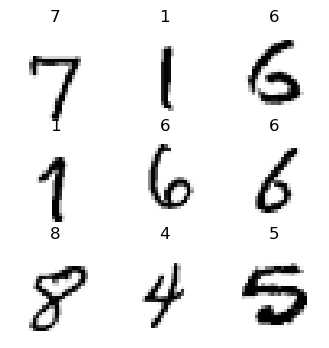

In [26]:
dls.show_batch(max_n=9, figsize=(4,4))

### A Simple Baseline CNN
Let’s start by building a basic convolutional neural network (CNN) as our baseline model. We can reuse the `conv` function from earlier, which makes it easy to build convolutional layers with configurable options.

In [27]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

#### Increasing Model Complexity
Given that our task now involves distinguishing 10 classes instead of just two, we likely need a more complex model with additional filters. Generally, doubling the number of filters at each stride-2 convolutional layer is beneficial, as it compensates for the reduction in spatial dimensions.

However, there’s a subtle problem to consider. In convolutional networks, feature extraction is effective only if the number of outputs at each layer is significantly smaller than the number of inputs. For example, if we use a 3×3 kernel (covering 9 pixels) and generate only four output filters, the model will still be forced to compress information meaningfully. But if we increase the filters without adjusting the kernel size, we risk having too few inputs per output feature, reducing the model's ability to learn effectively.

To address this, we increase the kernel size in the first layer to 5×5, covering 25 pixels. This setup provides a more substantial input for each output feature, enhancing feature extraction:

In [28]:
def simple_cnn():
    return sequential(
        conv(1 ,8, ks=5),        #14x14
        conv(8 ,16),             #7x7
        conv(16,32),             #4x4
        conv(32,64),             #2x2
        conv(64,10, act=False),  #1x1
        Flatten(),
    )

### Analyzing Model Training with Activation Statistics
To better understand the behavior of our model during training, we can use the `ActivationStats` callback. This callback records the mean, standard deviation, and histogram of activations at each layer. Examining these statistics allows us to detect issues such as activation values becoming too small (near zero) or too large, both of which can lead to training instability.

In [29]:
from fastai.callback.hook import *
def fit(epochs=1):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.06)
    return learn
learn = fit()

This initial attempt may result in poor training. Let’s diagnose why by examining activation statistics. `ActivationStats` provides a utility, `plot_layer_stats(idx)`, to visualize the mean, standard deviation, and percentage of activations near zero for each layer. Here’s an example for the first layer:

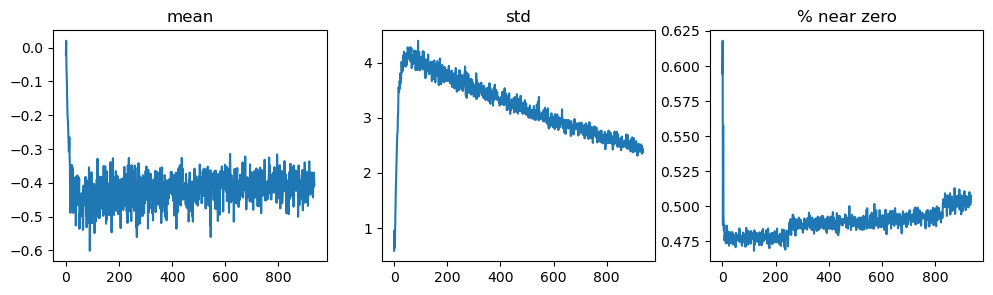

In [30]:
learn.activation_stats.plot_layer_stats(0)

Ideally, the mean and standard deviation should remain stable or follow a smooth trend. A high percentage of activations near zero indicates that a significant portion of the model is inactive or contributing minimally, which can propagate through layers, worsening at deeper levels.

Now let’s check the penultimate layer:

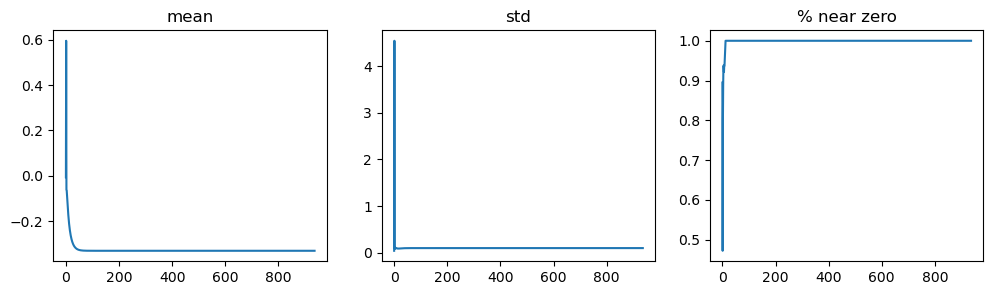

In [31]:
learn.activation_stats.plot_layer_stats(-2)

As expected, instability and zero activations often increase towards the end of the network, suggesting that some layers are "dead" and effectively passing zero values forward. This issue compounds through layers, making training difficult

### Batch Size and Gradient Stability

Increasing the batch size is a common technique to stabilize training. Mathematically, a larger batch size provides a better approximation of the population gradient by reducing the variance of the gradient estimate $\nabla L$, where $L$ is the loss function. Formally, if the true gradient of the loss $L$ over the entire dataset is represented as $\nabla L$, then the gradient computed with mini-batch $B$ of size $N$ can be written as:

$$
\nabla L_B = \frac{1}{N} \sum_{i=1}^N \nabla L(x_i, y_i)
$$

where $(x_i, y_i)$ are the data-label pairs in the batch. As $N$ increases, $\nabla L_B$ converges to $\nabla L$, which generally results in more stable gradient updates. However, larger batches reduce the number of parameter updates per epoch, which may slow down convergence in certain cases.

Let's see if a batch size of 512 helps:

In [32]:
dls = get_dls(512)

In [33]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,2.308856,2.304741,0.113500,01:10


Let's see what the penultimate layer looks like:

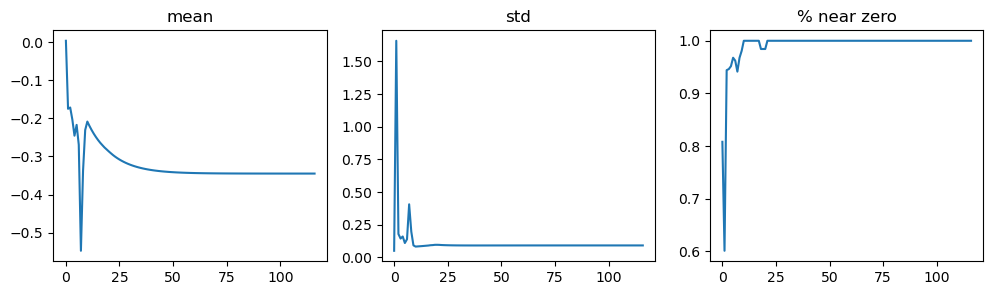

In [34]:
learn.activation_stats.plot_layer_stats(-2)

Again, we've got most of our activations near zero. Let's see what else we can do to improve training stability.

### 1cycle Training: Dynamic Learning Rates and Momentum

1cycle training, introduced in [Smith’s "Super-Convergence"](https://arxiv.org/abs/1708.07120), involves a two-phase learning rate schedule to stabilize and speed up training. The learning rate $ \alpha $ follows a schedule that initially increases during a warmup phase and then decreases during an annealing phase, effectively performing a one-cycle loop. Mathematically, this schedule is expressed as:

$$
\alpha(t) = 
\begin{cases} 
      \alpha_{\text{min}} + \frac{t}{T} \left( \alpha_{\text{max}} - \alpha_{\text{min}} \right) & \text{for} \; t \leq T \\
      \alpha_{\text{max}} - \frac{(t - T)}{T} \left( \alpha_{\text{max}} - \alpha_{\text{min}} \right) & \text{for} \; t > T 
   \end{cases}
$$

where $t$ is the current iteration, $T$ is the halfway point, $\alpha_{\text{min}}$ and $\alpha_{\text{max}}$ are the minimum and maximum learning rates, respectively. This cyclic schedule allows models to avoid poor local minima, leveraging high learning rates for rapid convergence and low learning rates for fine-tuning.

1cycle training allows us to use a much higher maximum learning rate than other types of training, which gives two benefits:

- By training with higher learning rates, we train faster—hence the *super-convergence* of the title.
- By training with higher learning rates, we overfit less because we skip over the sharp local minima to end up in a smoother (and therefore more generalizable) part of the loss.

The second point is an interesting and subtle one; it is based on the observation that a model that generalizes well is one whose loss would not change very much if you changed the input by a small amount. If a model trains at a large learning rate for quite a while, and can find a good loss when doing so, it must have found an area that also generalizes well, because it is jumping around a lot from batch to batch (that is basically the definition of a high learning rate). The problem is that, as we have discussed, just jumping to a high learning rate is more likely to result in diverging losses, rather than seeing your losses improve. So we don't jump straight to a high learning rate. Instead, we start at a low learning rate, where our losses do not diverge, and we allow the optimizer to gradually find smoother and smoother areas of our parameters by gradually going to higher and higher learning rates.

Then, once we have found a nice smooth area for our parameters, we want to find the very best part of that area, which means we have to bring our learning rates down again. This is why 1cycle training has a gradual learning rate warmup, and a gradual learning rate cooldown. Many researchers have found that in practice this approach leads to more accurate models and trains more quickly. 

We can use 1cycle training in fastai by calling `fit_one_cycle`:

In [35]:
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

In [36]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.210347,0.074806,0.974900,01:09


We're finally making some progress! It's giving us a reasonable accuracy now.

We can view the learning rate and momentum throughout training by calling `plot_sched` on `learn.recorder`. 

`learn.recorder` (as the name suggests) records everything that happens during training, including losses, metrics, and hyperparameters such as learning rate and momentum:

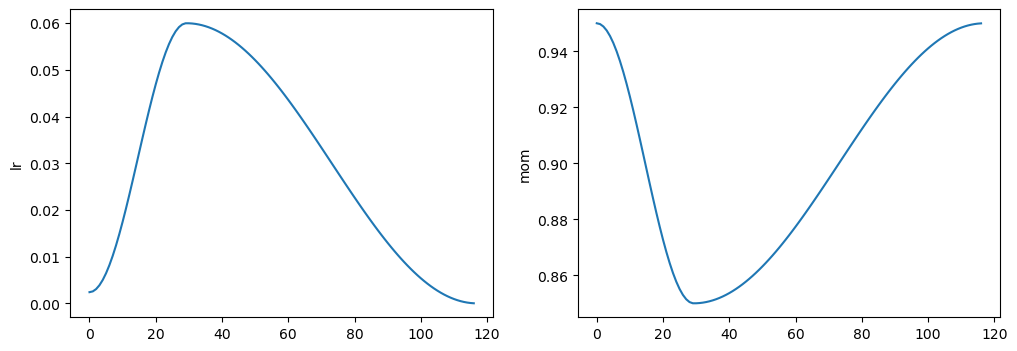

In [37]:
learn.recorder.plot_sched()

Let's take a look at our layer stats again:

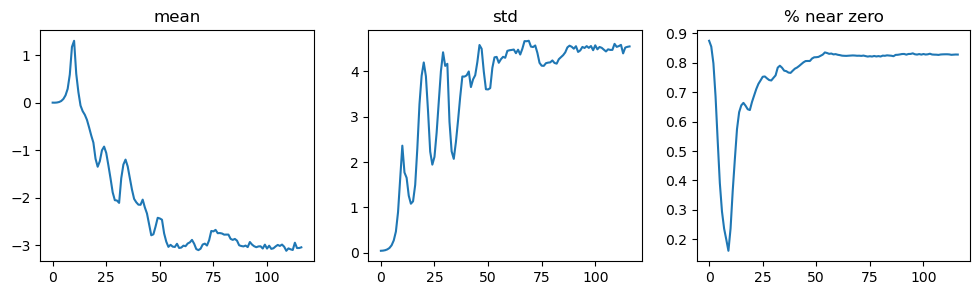

In [38]:
learn.activation_stats.plot_layer_stats(-2)

The percentage of near-zero weights is getting much better, although it's still quite high.

This shows a classic "bad training." We start with nearly all activations at zero. Then, over the first few batches we see the number of nonzero activations exponentially increasing. But it goes too far, and collapses! It almost looks like training restarts from scratch. 

It's much better if training can be smooth from the start. The cycles of exponential increase and then collapse tend to result in a lot of near-zero activations, resulting in slow training and poor final results. One way to solve this problem is to use batch normalization.

### Batch Normalization

Batch Normalization (BatchNorm) mitigates the problem of **internal covariate shift**—the change in the distribution of layer inputs during training. By normalizing activations within each mini-batch, BatchNorm helps stabilize and accelerate training.

Mathematically, for each mini-batch, BatchNorm computes the mean and variance of activations $ \mu_B $ and $ \sigma_B^2 $, and then normalizes each activation $ x_i $ as:

$$
\hat{x}_i = \frac{x_i - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}
$$

where $ \epsilon $ is a small constant added for numerical stability. This normalized activation $ \hat{x}_i $ is then scaled and shifted using learnable parameters $\gamma$ and $\beta$:

$$
y_i = \gamma \hat{x}_i + \beta
$$

The parameters $\gamma$ and $\beta$ allow the model to maintain any mean and standard deviation for each layer that it deems optimal, enhancing flexibility and capacity. During inference, the running averages of $\mu_B$ and $\sigma_B^2$ (computed over training batches) are used for consistent normalization.


In [39]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

and fit our model:

In [40]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.133975,0.058637,0.985600,01:10


That's even better! Let's take a look at the activation stats:

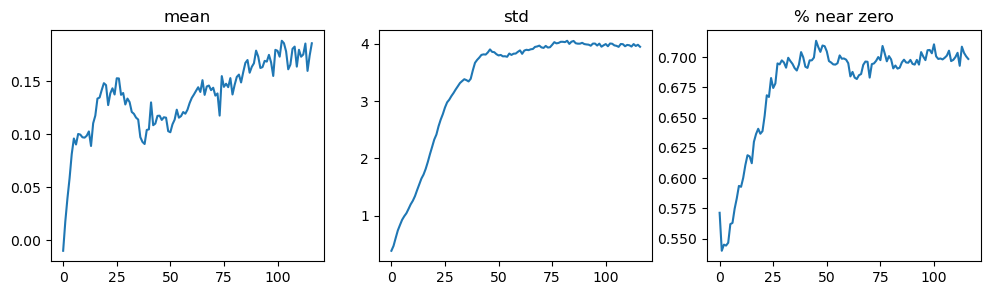

In [41]:
learn.activation_stats.plot_layer_stats(-2)

This is closer to what we hope to see: a smooth development of activations, with no "crashes". This gives us a hint of why batchnorm has been so successful that we see it (or something very similar) in nearly all modern neural networks.


BatchNorm acts as a form of **regularization** by introducing slight stochasticity to the model’s activations during training, as each mini-batch’s statistics vary slightly. This randomness makes the model robust to small variations, leading to improved generalization. It has been empirically observed that BatchNorm often leads to better test performance and a reduction in overfitting compared to networks that do not include it.

---


## From Fully Connected Layers to Convolutions

So far, fully connected neural networks (MLPs) have been our main tool. They work well for **tabular data**, where each row corresponds to an example and each column to a feature. In this setting, we make no assumptions about how features interact; all dependencies must be learned directly.

However, when we move to **high-dimensional perceptual data**, such as images or audio, this approach quickly breaks down. Consider image classification. Suppose we want to distinguish cats from dogs using photographs of size $1000 \times 1000$ pixels (one megapixel). Flattening the image yields a million input features. Even if we reduce to just $1000$ hidden units, a fully connected layer would require

$$
10^6 \times 10^3 = 10^9 \quad \text{parameters},
$$

just for one layer. Scaling such a network would demand massive datasets, distributed optimization across many GPUs, and enormous patience. And in practice, effective models would require even *larger* hidden layers, pushing parameter counts into the billions.

Humans, of course, recognize cats and dogs effortlessly. Computers also manage it with modern deep learning models. The resolution of this apparent contradiction is that **images are not just arbitrary vectors—they have structure**. Neighboring pixels are related, objects appear at different locations but retain their identity, and patterns repeat across space. Convolutional neural networks (CNNs) were designed specifically to exploit this structure.


### Invariance: Why Location Shouldn’t Matter

Imagine trying to detect Waldo in a picture. Waldo looks the same whether he is at the top or the bottom of the image. We want a detector that recognizes him *regardless of location*. This is the principle of **translation invariance** (or more precisely, *translation equivariance* at intermediate layers).

Humans exploit this naturally—we can recognize shapes even if they appear shifted. CNNs encode this property by scanning the image with small filters that apply the same weights across all positions. Thus, instead of learning a separate parameter for every possible pixel-to-hidden-unit connection, we reuse the same filter everywhere.

Two guiding principles emerge:

1. **Translation invariance:** shifting the input should correspond to shifting the representation, not fundamentally changing it.
2. **Locality:** early features should depend only on local regions, not the entire image at once.
3. **Hierarchy:** deeper layers combine local features into larger, more abstract representations.

Together, these principles let CNNs learn effective models with far fewer parameters.



### Constraining the MLP

To see how convolutions arise, let’s start from a fully connected view. Suppose the input image is $\mathbf{X}$ and the hidden representation is $\mathbf{H}$, both treated as 2D arrays of the same shape. Then each hidden unit $[\mathbf{H}]_{i,j}$ depends on all input pixels:

$$
[\mathbf{H}]_{i,j} = [\mathbf{U}]_{i,j} + \sum_k \sum_l [\mathsf{W}]_{i,j,k,l} \,[\mathbf{X}]_{k,l},
$$

where $\mathsf{W}$ is a fourth-order weight tensor and $\mathbf{U}$ contains biases.

This is already unrealistic: for a $1000 \times 1000$ image, $\mathsf{W}$ contains $10^{12}$ parameters—far beyond current hardware limits.

#### Step 1: Translation Invariance

If we require that shifting $\mathbf{X}$ simply shifts $\mathbf{H}$, then the weights cannot depend on $(i,j)$ explicitly. Instead, the weights depend only on offsets $(a,b)$ relative to the current location:

$$
[\mathbf{H}]_{i,j} = u + \sum_a \sum_b [\mathbf{V}]_{a,b}\,[\mathbf{X}]_{i+a, j+b}.
$$

Here $\mathbf{V}$ is shared across the image, and $u$ is a global bias. This is exactly the definition of a **convolution**. Already, the number of parameters drops dramatically, since we no longer need a separate weight tensor for each location.

#### Step 2: Locality

Next, we impose **locality**: nearby pixels are most relevant. This means that offsets are limited to a small neighborhood:

$$
[\mathbf{H}]_{i,j} = u + \sum_{a=-\Delta}^{\Delta} \sum_{b=-\Delta}^{\Delta} [\mathbf{V}]_{a,b}\,[\mathbf{X}]_{i+a, j+b}.
$$

This is the **convolutional layer**, where $\Delta$ controls the *receptive field size*. Typically, $\Delta \leq 3$, so filters are tiny ($3\times 3$ or $5\times 5$). The parameter count now shrinks from trillions to just a few dozen per filter.

By stacking many such layers, deeper networks can capture broader context: small filters combine into larger receptive fields, enabling recognition of global structures from local building blocks.

### Convolutions and Cross-Correlation

Mathematically, convolution between functions $f,g:\mathbb{R}^d\to\mathbb{R}$ is defined as

$$
(f * g)(\mathbf{x}) = \int f(\mathbf{z})\, g(\mathbf{x}-\mathbf{z})\, d\mathbf{z}.
$$

In discrete 2D form:

$$
(f * g)(i,j) = \sum_a \sum_b f(a,b)\, g(i-a, j-b).
$$

In deep learning libraries, however, the operation is usually implemented as **cross-correlation**, which replaces $(i-a,j-b)$ with $(i+a,j+b)$. The difference is only a flip in indexing, and in practice both are referred to as “convolution.”

### Channels: From Grayscale to RGB and Beyond

So far we treated images as 2D grids. Real images, however, have **channels** (e.g., RGB). Thus, the input is a 3D tensor $\mathsf{X}_{i,j,c}$ with height, width, and channel dimensions. The hidden representation is also 3D, now with multiple *feature maps*.

The convolution filter must therefore handle channels. A filter is defined as $\mathsf{V}_{a,b,c,d}$, where $c$ indexes input channels and $d$ indexes output channels. The operation is:

$$
[\mathsf{H}]_{i,j,d} = \sum_{a=-\Delta}^{\Delta} \sum_{b=-\Delta}^{\Delta} \sum_c [\mathsf{V}]_{a,b,c,d}\,[\mathsf{X}]_{i+a,j+b,c}.
$$

Thus each output channel $d$ is computed as a weighted combination of local regions across *all* input channels. Different filters can specialize: some detect edges, others textures or color patterns. By stacking layers, higher-level features emerge—like shapes, objects, and eventually categories.

### Why This Works

* **Parameter efficiency:** billions of parameters shrink to a few thousand.
* **Inductive bias:** convolution encodes translation invariance and locality, properties true of natural images.
* **Hierarchical learning:** shallow filters capture edges, deeper filters combine them into textures, shapes, and semantic objects.

The cost is that we impose assumptions (e.g., translation invariance). If these assumptions fail, CNNs may struggle. But in vision and many perceptual tasks, they align well with reality, making CNNs the backbone of modern computer vision.